In [71]:
using LinearAlgebra
using Plots
using Ripserer
using CSV
using Distances
using AbstractAlgebra
using AbstractAlgebra
using Oscar
using SparseArrays
using StatsBase
include("circ_coord.jl")

using IterativeSolvers
using MultivariateStats
using LinearAlgebra

verify_coefficients_indexed (generic function with 1 method)

In [2]:
"""
Our field of choice to compute persitence cohomology
"""

ph_field = 47

47

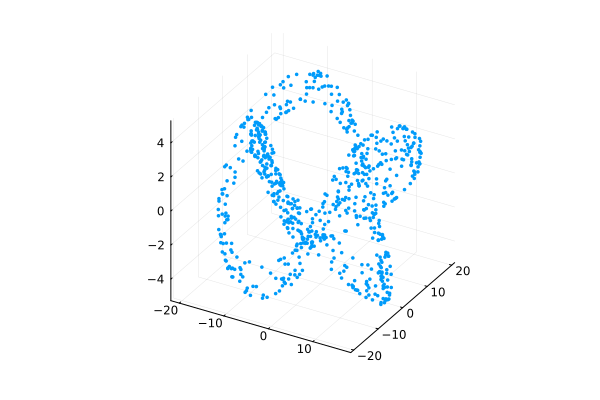

In [5]:
filename = "trefoil_2.csv"

data = [(row[1], row[2], row[3]) for row in CSV.File(filename, header=false)]

data = data[1:2:end]


x_coords = getindex.(data, 1)
y_coords = getindex.(data, 2)
z_coords = getindex.(data, 3)

data_matrix = hcat(x_coords, y_coords, z_coords)'

distance_matrix = pairwise(Euclidean(), data_matrix);

using Plots
#plotlyjs() # Sets the backend to PlotlyJS for interactive plots
x_coords = [p[1] for p in data]
y_coords = [p[2] for p in data]
z_coords = [p[3] for p in data]

scatter3d(
    x_coords, 
    y_coords, 
    z_coords,
    markersize=2,         # Adjust the size of the points
    markerstrokewidth=0,  # Removes the border from points for a cleaner look
    legend=false          # No need for a legend with only one data series
)


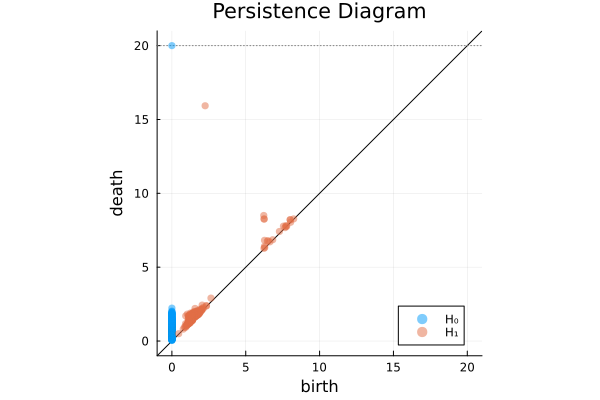

In [19]:
threshold_ = 20


"""

Compute Persistence cohomology

"""

rips = Ripserer.Rips(distance_matrix, sparse = false, threshold = threshold_)

diagram_cocycles = ripserer(rips; reps=[1], field = Ripserer.Mod{ph_field})
thresh_for_X = 5.1 # Pick a low threshold

plot(diagram_cocycles)



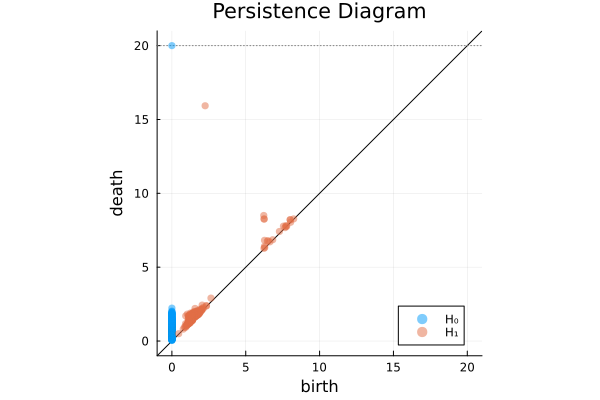

In [72]:
"""

Compute Persistence homology

"""


rips_ho = Ripserer.Rips(distance_matrix, sparse = false, threshold = threshold_)

diagram_cycles = ripserer(rips_ho; alg=:involuted, field = Ripserer.Mod{ph_field}, reps=[1])
plot(diagram_cycles)


In [73]:

"""
We look at the same point for homology/cohomology, the most persistence feature
"""

LOOK_AT_COCYCLE = 0
LOOK_AT_CYCLE = 0;

In [74]:
most_persistent_co = diagram_cocycles[2][end - LOOK_AT_COCYCLE]
cocycle = Ripserer.representative(most_persistent_co);
simps_co = Ripserer.vertices.(cocycle);
simps_co = simps_co[ Ripserer.birth.(cocycle) .< thresh_for_X]
cocycle = cocycle[ Ripserer.birth.(cocycle) .< thresh_for_X];

In [75]:
most_persistent_ho = diagram_cycles[2][end- LOOK_AT_CYCLE]
cycle = Ripserer.representative(most_persistent_ho);
simps_ho = Ripserer.vertices.(cycle);


In [76]:
"""
In order to successfully lift the cycle to an integer cycle, we need to scale it by 2.
The cocycle already has coefficients in the proper range
"""

SCALE_COCYCLE = 1
SCALE_CYCLE = 2

2

In [81]:
coeff_co = Ripserer.coefficient.(cocycle);
coeff_co = coeff_co*SCALE_COCYCLE

α = Int.(coeff_co);
α[α .>= ph_field÷2] .-= ph_field;
α = Int.(α*1);
countmap(Int.(α))

Dict{Int64, Int64} with 2 entries:
  2  => 57
  -2 => 33

In [85]:
coeff_ho = coefficient.(cycle)
coeff_ho = coeff_ho*SCALE_CYCLE;
countmap(Int.(coeff_ho))

Dict{Int64, Int64} with 4 entries:
  2  => 29
  45 => 31
  46 => 108
  1  => 109

In [86]:
"""
If this prints something, we cant lift the cycle. If its quite, then its no problem
"""

verify_coefficients_indexed(simps_ho, Int.(coeff_ho), ph_field)


In [87]:
β = Int.(coeff_ho);
β[β .>= ph_field÷2] .-= ph_field;
β = 1*β;

In [91]:
"""

Compute the Kronecker pairing to deduce the winding number of the cocycle

"""

res = 0
for i in 1:length(coeff_co)
    index = findfirst(isequal(simps_co[i]), simps_ho)
    if index !== nothing
        print("Index: ", index,", Values: COHO ", α[i]," * HO ", β[index])
        res += α[i]*β[index]
    end
end
res # This returns 2 either the cycle or cocycle has winding number ±2.

Index: 1, Values: COHO 2 * HO 1

2

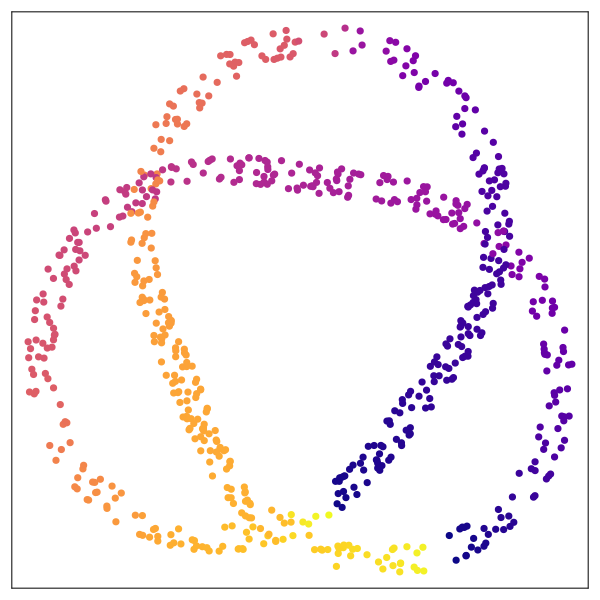

In [97]:
"""
We lift the cocycle we found and compute the circular coordinates
"""

edges_X  =  Ripserer.vertices.(Ripserer.edges(rips))[birth.(Ripserer.edges(rips)) .< thresh_for_X]
D_tilde, simps_tilde, L1_dim = build_complex_and_boundary_operator(Ripserer.vertices(rips), edges_X);
multpl = 1
cocycle = cocycle[birth.(cocycle) .< thresh_for_X]
base_change_cocycle_tilde = base_change(D_tilde, cocycle, ph_field, multpl);
countmap(base_change_cocycle_tilde)

θ = mod.(Array(IterativeSolvers.lsmr(transpose(D_tilde[1:size(data)[1],1:L1_dim ]), base_change_cocycle_tilde[1:L1_dim])), 1.0);

data_matrix = stack(data)

M = fit(PCA, data_matrix; maxoutdim=2, pratio=1.0)
reduced_data = MultivariateStats.transform(M, data_matrix)

scatter(reduced_data[1,:], reduced_data[2,:],
    zcolor = θ,
    c = :plasma,
    framestyle = :box,
    ticks = nothing,
    colorbar = false,
    legend = false,
    markerstrokewidth = 0,  # Removes the outline from the points
    size = (600, 600)
)

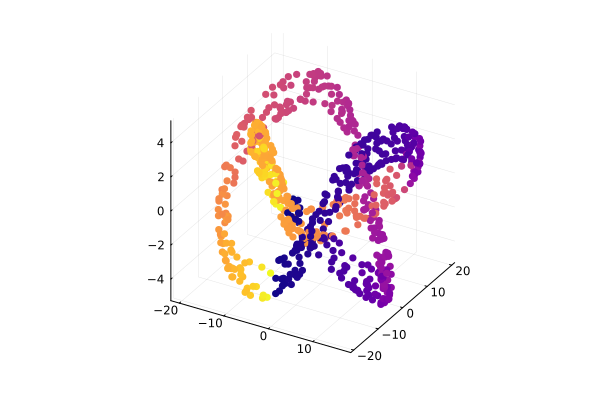

In [101]:
"""
We also include a 3D plot of the trefoil with the circular coordinates.
"""

x_coords = [point[1] for point in data]
y_coords = [point[2] for point in data]
z_coords = [point[3] for point in data]


scatter(x_coords, y_coords, z_coords,
    zcolor = θ,
    color = :plasma,
    legend = false,
    markerstrokewidth = 0,
    markersize = 4
)

In [107]:
"""
We need to check if the cocycle as winding number 2
"""

field_to_check = 2
F = AbstractAlgebra.GF(field_to_check)

Finite field F_2

In [110]:

"""
The cocycle has winding number zero if it is a boundary mod 2. This is trivially true in this case as the 
GCD of the coordinates of the cocycle is 2. 
However, we do the algorithm the a general.
"""

D_tilde_mod_F = sparse_matrix(F,Array(D_tilde[1:L1_dim, 1:L1_dim]))
    
base_change_cocycle_tilde_2_mod_F = sparse_matrix(F,Array(reshape(deepcopy(base_change_cocycle_tilde[1:L1_dim]),:, 1)))   

"""

IF this fails to find a solution, i.e., returns False, it means that base_change_cocycle_tilde_2_mod_F is not a boundary mod field_to_check.

IF this returns true then the winding number divides 2

"""

cocycle_a_boundary_questionmark = Oscar.can_solve(transpose(D_tilde_mod_F), base_change_cocycle_tilde_2_mod_F)


true

In [113]:
order_of_alpha = 2

2

In [144]:
"""
We choose some field to do the calculations as in Proposition 4.4 and proceed with a step in Algorithm 1.
We only need one step.
"""

big_field = 47
big_F = AbstractAlgebra.GF(big_field)
slice = base_change_cocycle_tilde[length(data)+1:L1_dim]
reshaped_slice = Array(reshape(base_change_cocycle_tilde[length(data)+1:L1_dim], length(slice), 1))
α_1 = sparse_matrix(big_F, reshaped_slice)
D_0 =  sparse_matrix(big_F, Array(transpose(D_tilde)[1:L1_dim-length(data),1:L1_dim]))
D_tilde_mod_F = sparse_matrix(big_F,Array(D_tilde[1:L1_dim, 1:L1_dim]))
identity_matri_times_order = Oscar.sparse_matrix(identity_matrix(big_F,L1_dim-length(data)))* order_of_alpha
A = hcat(identity_matri_times_order, D_0)
γ = Array(Oscar.solve(A, α_1))[:,1];

In [146]:
"""
In order to proceed we need that these values are liftable, i.e., in {-p/3, ... ,-1, 0, 1, ..., p/3}
"""

countmap(lift.(γ)) #it is ok

Dict{BigInt, Int64} with 3 entries:
  0  => 13894
  46 => 33
  1  => 57

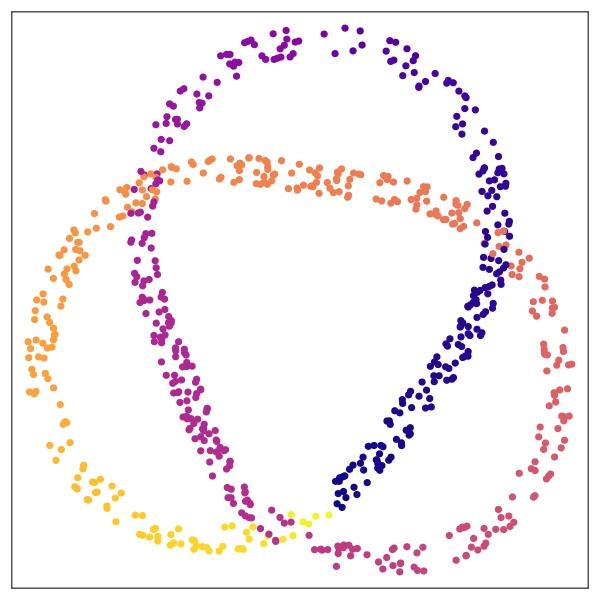

In [150]:
"""
We compute the circular coordinates of γ
"""

new_gamma = Int.([zeros(length(data)); lift.(Array(γ)[:,1] * mult_to_fix) ; zeros(size(D_tilde, 1) - L1_dim)])
unique(new_gamma)
new_gamma[new_gamma .>= big_field÷2] .-= big_field
new_gamma = 1*new_gamma

θ = mod.(Array(IterativeSolvers.lsmr(transpose(D_tilde), new_gamma)[1:size(data,1)]), 1.0);

data_matrix = stack(data)

M = fit(PCA, data_matrix; maxoutdim=2, pratio=1.0)
reduced_data = MultivariateStats.transform(M, data_matrix)
scatter(reduced_data[1,:], reduced_data[2,:],
    zcolor = θ,
    c = :plasma,
    framestyle = :box,
    ticks = nothing,
    colorbar = false,
    legend = false,
    markerstrokewidth = 0,  # Removes the outline from the points
    size = (600, 600)
)